In [2]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import datetime
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.python.ops import rnn, rnn_cell
import matplotlib.pyplot as plt
import cPickle
import gzip
import math
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 提取主力合约数据，已经加入了MA、EMA、MACD等指标

In [3]:
# 提取主力合约数据
path = '/home/chocolate/LSTM-source/'
data = pd.read_csv(path + 'train_data_addMA.csv')
data=data.ix[:,2:]
data = data.fillna(0)
# data['RaiseDown'] = (data['Latestprice'] - data['First.Latestprice'])/data['First.Latestprice']

In [4]:
# 为主力合约数据添加两个特征：平均价和下一分钟涨跌幅
# 其中，平均价为当前分钟的四个价格的平均值
# 下一分钟的涨跌幅为（下一分钟平均价 - 当前分钟平均价）/当前分钟平均价
data['MeanPrice'] = (data['Latestprice'] + data['First.Latestprice'] +data['MaxPrice']+data['MinPrice'])/4
ser1 = data['MeanPrice'][1:]
ser1.index = range(len(ser1))
ser2 = data['MeanPrice'][:-1]
ser2.index = range(len(ser2))
data['RaiseDown'] = (ser1 -ser2)/ser2
data = data.fillna(0)
data

,Latestprice,MaxPrice,MinPrice,Stockup,Turnover,Position,Volume,First.Latestprice,Last.Buy1price,Last.Buy1quantity,...,Dis_Vol_MA5_26,Vol_EMA_5,Vol_EMA_12,Vol_EMA_26,Dis_Vol_EMA5_26,DIFF_12_26,DEA_12_26,MACD,MeanPrice,RaiseDown
0,3640.4,3646.0,3640.2,-63,115844340,28315,106,3644.8,3640.2,2,...,0.000000,106.000000,106.000000,106.000000,0.000000,0.000000,0.000000,0.000000,3642.85,-0.002704
1,3625.8,3641.4,3624.4,-79,228902820,28236,210,3640.4,3625.0,4,...,0.000000,168.400000,162.333333,160.000000,8.400000,-0.327564,-0.181980,-0.291168,3633.00,-0.003331
2,3618.8,3626.8,3612.6,-110,301745580,28126,278,3625.4,3619.2,1,...,0.000000,220.315789,207.478060,202.396254,17.919535,-0.634451,-0.367419,-0.534064,3620.90,-0.000801
3,3617.0,3620.2,3616.0,-81,162817740,28045,150,3618.8,3616.8,5,...,0.000000,191.107692,189.334483,187.748551,3.359141,-0.823469,-0.521908,-0.603123,3618.00,-0.000373
4,3618.0,3618.8,3613.0,-66,143205060,27979,132,3616.8,3618.0,2,...,0.000000,168.417062,173.756909,174.820232,-6.403171,-0.869050,-0.625175,-0.487751,3616.65,0.000843
5,3621.0,3621.6,3618.0,-47,111857580,27931,103,3618.2,3621.0,1,...,0.000000,144.512782,156.559257,160.435213,-15.922431,-0.751834,-0.659506,-0.184655,3619.70,-0.000553
6,3614.2,3621.4,3614.2,-46,120504420,27885,111,3621.0,3612.8,2,...,0.000000,132.647402,146.392868,151.643416,-18.996015,-0.971763,-0.738530,-0.466465,3617.70,-0.002750
7,3601.2,3615.6,3600.0,-98,372121500,27787,344,3614.2,3601.0,1,...,0.000000,205.958763,187.630431,182.636828,23.321935,-1.721885,-0.974849,-1.494072,3607.75,-0.001289
8,3602.2,3608.6,3600.4,-68,195712320,27719,181,3601.2,3602.2,2,...,0.000000,197.416984,186.318696,182.394214,15.022770,-2.165518,-1.249899,-1.831237,3603.10,0.000111
9,3604.6,3608.4,3599.0,-70,198897300,27649,184,3602.0,3603.4,1,...,0.000000,192.865730,185.879304,182.615797,10.249933,-2.325090,-1.490804,-1.668572,3603.50,-0.000139


In [130]:
max(data['RaiseDown']),min(data['RaiseDown'])

(0.026806102525068671, -0.033535366458236689)

In [5]:
data_array = np.array(data)
data_array

array([[  3.64040000e+03,   3.64600000e+03,   3.64020000e+03, ...,
          0.00000000e+00,   3.64285000e+03,  -2.70392687e-03],
       [  3.62580000e+03,   3.64140000e+03,   3.62440000e+03, ...,
         -2.91168091e-01,   3.63300000e+03,  -3.33058079e-03],
       [  3.61880000e+03,   3.62680000e+03,   3.61260000e+03, ...,
         -5.34064377e-01,   3.62090000e+03,  -8.00905852e-04],
       ..., 
       [  3.30420000e+03,   3.30680000e+03,   3.30420000e+03, ...,
         -6.88750506e-01,   3.30525000e+03,  -2.11784283e-04],
       [  3.30480000e+03,   3.30540000e+03,   3.30380000e+03, ...,
         -7.60078129e-01,   3.30455000e+03,   1.51306532e-04],
       [  3.30500000e+03,   3.30620000e+03,   3.30400000e+03, ...,
         -7.51367561e-01,   3.30505000e+03,   0.00000000e+00]])

## 对数据进行标准化

In [6]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_array = min_max_scaler.fit_transform(data_array)
data_array

array([[ 1.        ,  1.        ,  1.        , ...,  0.65315817,
         1.        ,  0.51094944],
       [ 0.98349537,  0.9947952 ,  0.98259529, ...,  0.64915289,
         0.98885873,  0.50056431],
       [ 0.97558218,  0.97827563,  0.96959683, ...,  0.64581164,
         0.97517249,  0.54248697],
       ..., 
       [ 0.61994122,  0.61620276,  0.62987442, ...,  0.64368379,
         0.61814274,  0.5522501 ],
       [ 0.62061949,  0.61461869,  0.6294338 , ...,  0.64270261,
         0.61735098,  0.55826737],
       [ 0.62084558,  0.61552387,  0.62965411, ...,  0.64282244,
         0.61791653,  0.55575986]])

## 生成5分钟的时间序列，变为3维数组

In [10]:

seq_5 = []
for j in range(len(data_array)):
    if j+5 < len(data_array):
        seq_5.append(data_array[j:j+5])
seq_5 = np.array(seq_5)
seq_5.shape

(35753, 5, 33)

# 进行涨跌情况的分类

## 提取训练集、测试集。根据下一分钟的涨跌幅分别打标签，分为五类

In [11]:
# 取前面10000个数据作为训练集
# 前面的数据点因有na值填充，会对准确性造成一定影响，因此从第1000个点开始
train_data = seq_5[1000:11000]
train_data.shape

(10000, 5, 33)

In [12]:
data1 = data[1000:11000]
train_label = []
for i in data1['RaiseDown']:
    if i > 0.002:
        train_label.append([1,0,0,0,0])   #大涨
    elif i > 0.0005:
        train_label.append([0,1,0,0,0])   #小涨
    elif i> -0.0005: 
        train_label.append([0,0,1,0,0])   #平稳
    elif i > -0.002:
        train_label.append([0,0,0,1,0])   #小跌
    else:
        train_label.append([0,0,0,0,1])   #大跌
train_label = np.array(train_label)
train_label.shape

(10000, 5)

In [15]:
# 统计五类情况各自的数量
train_label_list = train_label.tolist()
print u'大涨：',train_label_list.count([1,0,0,0,0])
print u'小涨：',train_label_list.count([0,1,0,0,0])
print u'平稳：',train_label_list.count([0,0,1,0,0])
print u'小跌：',train_label_list.count([0,0,0,1,0])
print u'大跌：',train_label_list.count([0,0,0,0,1])

大涨： 244
小涨： 2136
平稳： 5124
小跌： 2313
大跌： 183


# 取后面2000个分钟数据作为测试集

In [16]:
test_data = seq_5[12000:14000]
test_data = np.array(test_data)
test_data.shape

(2000, 5, 33)

In [19]:
data2 = data[12000:14000]
test_label = []
for i in data2['RaiseDown']:
    if i > 0.002:
        test_label.append([1,0,0,0,0])
    elif i > 0.0005:
        test_label.append([0,1,0,0,0])
    elif i> -0.0005:
        test_label.append([0,0,1,0,0])
    elif i > -0.002:
        test_label.append([0,0,0,1,0])
    else:
        test_label.append([0,0,0,0,1])
test_label = np.array(test_label)
test_label.shape

(2000, 5)

In [20]:
test_label_list = test_label.tolist()
# 测试集五类样本的数量
print u'大涨：', test_label_list.count([1,0,0,0,0])
print u'小涨：', test_label_list.count([0,1,0,0,0])
print u'平稳：', test_label_list.count([0,0,1,0,0])
print u'小跌：', test_label_list.count([0,0,0,1,0])
print u'大跌：', test_label_list.count([0,0,0,0,1])

大涨： 17
小涨： 320
平稳： 1304
小跌： 349
大跌： 10


# 开始构建LSTM网络，进行分类准确率测试

In [172]:
learning_rate = 0.001 # 学习速率
training_iters = 10000  # 训练总步长
batch_size = 50  # 每小段步长
display_step = 10  # 每隔十小段显示输出

# 参数设置
n_input = 33 # 特征数量
n_steps = 5 # 时间序列长度
n_hidden = 500 # 隐藏层神经元个数
n_classes = 5 # 分类数量

tf.reset_default_graph()  # 重置流图
# 设置输入输出格式大小
xtr = tf.placeholder("float", [None, n_steps, n_input])
ytr = tf.placeholder("float", [None,n_classes])
# xte = tf.placeholder("float", [None, n_steps, n_input])
# yte = tf.placeholder("float", [None,n_classes])
xtr1 = tf.placeholder("float", [None, n_input*n_steps])  
xte1 = tf.placeholder("float", [n_input*n_steps])  
# 定义权重和偏移量
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# def pred():
    
def RNN(x, weights, biases):

    # 更改数据集的格式，使其满足RNN网络的输入需求
    # 现在输入格式: (batch_size, n_steps, n_input)
    # 需要的格式: 'n_steps' 个tensor，每个的格式为 (batch_size, n_input)

    # 变换batch_size 和 n_steps的位置
    x = tf.transpose(x, [1, 0, 2])
    # 重新调整格式 (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # 分割成一系列的 'n_steps' 个tensors，每个的格式为 (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # 定义LSTM神经网络结构
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # 获取输出和状态
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)
    # 返回输出
    return tf.matmul(outputs[-1], weights['out']) + biases['out']
# 获取预测值
pred = RNN(xtr, weights, biases)
# train_label = tf.split(0, batch_size, train_label)
# 取下一小段的输入
def next_batch_tr(step, batch_size):
    return train_data[(step-1)*batch_size:step*batch_size], train_label[(step-1)*batch_size:step*batch_size]
def next_batch_te(step, batch_size):
    return test_data[(step-1)*batch_size:step*batch_size], test_label[(step-1)*batch_size:step*batch_size]

Xtr1 = np.reshape(train_data, newshape=(-1, n_input*n_steps))  
Xte1 = np.reshape(test_data, newshape=(-1, n_input*n_steps)) 
Xtr2 = map(map, [float, float], Xtr1)
Xte2 = map(map, [float, float], Xte1)
Xtr3 = np.array(Xtr2)
Xte3 = np.array(Xte2)


In [173]:
# 定义代价函数和最优化方法
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, ytr))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# 评估模型准确率
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(ytr, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 定义相似度，即预测值与训练值的距离
distance = tf.reduce_sum(tf.abs(tf.add(xtr1, tf.neg(xte1))), reduction_indices=1)  
# 预测值: 获取相似度最高的训练标签，作为预测标签
pred1 = tf.arg_min(distance, 0)  
# 变量初始化
init = tf.initialize_all_variables()

# 创建会话
sess = tf.InteractiveSession()
sess.run(init)
step = 1
    # 一直迭代，直到最大步长
while step * batch_size < training_iters:
    batch_x, batch_y = next_batch_tr(step, batch_size)
    batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # 利用最优化方法调整权值
    sess.run(optimizer, feed_dict={xtr: batch_x, ytr: batch_y})
    if step % display_step == 0:
            # 计算准确率和损失函数
        acc = sess.run(accuracy, feed_dict={xtr: batch_x, ytr: batch_y})
        loss = sess.run(cost, feed_dict={xtr: batch_x, ytr: batch_y})
        # 每隔一定步长显示训练准确率和损失率
        print("Iter " + str(step * batch_size) + ", Minibatch Loss= " +
                "{:.6f}".format(loss) + ", Training Accuracy= " +
                "{:.5f}".format(acc))
    step += 1
print("Optimization Finished!")

    # 计算n个预测值的预测准确率
test_len = 100
test_data = test_data[:test_len].reshape((-1, n_steps, n_input))
test_label = test_label[:test_len]
print("Testing Accuracy:",
        sess.run(accuracy, feed_dict={xtr: test_data, ytr: test_label}))

for i in range(test_len):  
        # 索引即为相似度最大的标签值
    nn_index = sess.run(pred1, feed_dict={xtr1: Xtr3, xte1: Xte3[i,:]})  
        # 打印出对应的预测标签和实际标签
    print "Test", i, "Prediction:", np.argmax(train_label[nn_index]), "True Class:", np.argmax(test_label[i])  

print "Done!"

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f7b2a378610>> ignored


Iter 500, Minibatch Loss= 3.195077, Training Accuracy= 0.36000
Iter 1000, Minibatch Loss= 1.577735, Training Accuracy= 0.38000
Iter 1500, Minibatch Loss= 1.418900, Training Accuracy= 0.48000
Iter 2000, Minibatch Loss= 1.398080, Training Accuracy= 0.40000
Iter 2500, Minibatch Loss= 1.507281, Training Accuracy= 0.30000
Iter 3000, Minibatch Loss= 1.288328, Training Accuracy= 0.38000
Iter 3500, Minibatch Loss= 0.855918, Training Accuracy= 0.70000
Iter 4000, Minibatch Loss= 1.138813, Training Accuracy= 0.58000
Iter 4500, Minibatch Loss= 1.086167, Training Accuracy= 0.52000
Iter 5000, Minibatch Loss= 0.851407, Training Accuracy= 0.72000
Iter 5500, Minibatch Loss= 1.126116, Training Accuracy= 0.54000
Iter 6000, Minibatch Loss= 1.005334, Training Accuracy= 0.72000
Iter 6500, Minibatch Loss= 1.412037, Training Accuracy= 0.38000
Iter 7000, Minibatch Loss= 1.066712, Training Accuracy= 0.54000
Iter 7500, Minibatch Loss= 1.789981, Training Accuracy= 0.26000
Iter 8000, Minibatch Loss= 1.216005, Trai

# 作出预测值和真实标签的对比

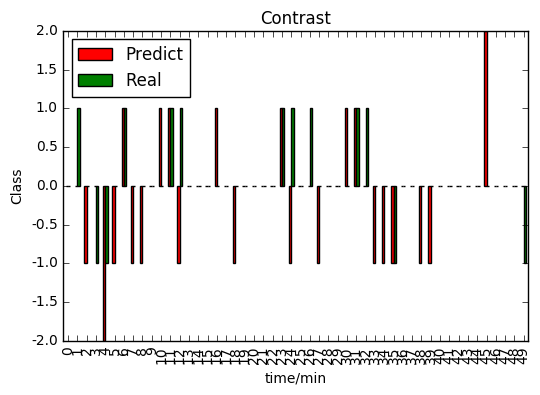

In [174]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-  
# 画出对比图，绿色表示实际值，红色表示预测值
import numpy as np    
import matplotlib.mlab as mlab    
import matplotlib.pyplot as plt    
# import ch
%matplotlib inline

# from pylab import *

# mpl.rcParams['font.sans-serif'] = ['SimHei']
# mpl.rcParams['axes.unicode_minus'] = False
Y1=[]
for i in range(15,65):
    nn_index = sess.run(pred1, feed_dict={xtr1: Xtr3, xte1: Xte3[i,:]})  
    Y1.append(2 - np.argmax(train_label[nn_index]))
Y2=[]
for i in range(15,65):
    Y2.append(2 - np.argmax(test_label[i]))

Y3 = pd.concat([Series(Y1),Series(Y2)],axis=1)
# set_ch()
Y3.columns = ['Predict','Real']
X=range(15,65)  
fig = plt.figure()  
Y3.plot(color=['red','green'],kind='bar',use_index=False)  
#plt.bar(X,Y2,0.4,color="red")  
plt.xlabel("time/min")  
plt.ylabel("Class")  
plt.title("Contrast")  

# 进行最高价的分类

In [98]:
train1_data = seq_5[2000:22000]
train1_data.shape

(20000, 5, 32)

In [99]:
data3 = data[2000:22000]
train1_label = []
for i in data3['MaxPrice']:
    if i < 3100:
        train1_label.append([1,0,0,0,0,0,0,0,0,0])   # 最高价 < 2800
    elif i < 3110:
        train1_label.append([0,1,0,0,0,0,0,0,0,0])   # 最高价 2800~2900
    elif i < 3120: 
        train1_label.append([0,0,1,0,0,0,0,0,0,0])   # 最高价 2900~3000
    elif i < 3130:
        train1_label.append([0,0,0,1,0,0,0,0,0,0])   # 最高价 3000~3100
    elif i < 3140:
        train1_label.append([0,0,0,0,1,0,0,0,0,0])   # 最高价 3100~3200
    elif i < 3150:
        train1_label.append([0,0,0,0,0,1,0,0,0,0])   # 最高价 3200~3300
    elif i < 3160:
        train1_label.append([0,0,0,0,0,0,1,0,0,0])   # 最高价 3300~3400
    elif i < 3170:
        train1_label.append([0,0,0,0,0,0,0,1,0,0])   # 最高价 3400~3500
    elif i < 3180:
        train1_label.append([0,0,0,0,0,0,0,0,1,0])   # 最高价 3500~3600
    else:
        train1_label.append([0,0,0,0,0,0,0,0,0,1])   # 最高价 > 3600
    
train1_label = np.array(train1_label)
train1_label.shape

(20000, 10)

In [100]:
train1_label_list = train1_label.tolist()
print train1_label_list.count([1,0,0,0,0,0,0,0,0,0])  
print train1_label_list.count([0,1,0,0,0,0,0,0,0,0]) 
print train1_label_list.count([0,0,1,0,0,0,0,0,0,0]) 
print train1_label_list.count([0,0,0,1,0,0,0,0,0,0])
print train1_label_list.count([0,0,0,0,1,0,0,0,0,0]) 
print train1_label_list.count([0,0,0,0,0,1,0,0,0,0]) 
print train1_label_list.count([0,0,0,0,0,0,1,0,0,0]) 
print train1_label_list.count([0,0,0,0,0,0,0,1,0,0]) 
print train1_label_list.count([0,0,0,0,0,0,0,0,1,0]) 
print train1_label_list.count([0,0,0,0,0,0,0,0,0,1]) 

11615
267
421
655
1086
598
403
400
587
3968


In [101]:
test1_data = seq_5[22000:23000]
test1_data.shape

(1000, 5, 32)

In [102]:
data4 = data[22000:23000]
test1_label = []
for i in data4['MaxPrice']:
    if i < 3100:
        test1_label.append([1,0,0,0,0,0,0,0,0,0])   # 最高价 < 2800
    elif i < 3110:
        test1_label.append([0,1,0,0,0,0,0,0,0,0])   # 最高价 2800~2900
    elif i < 3120: 
        test1_label.append([0,0,1,0,0,0,0,0,0,0])   # 最高价 2900~3000
    elif i < 3130:
        test1_label.append([0,0,0,1,0,0,0,0,0,0])   # 最高价 3000~3100
    elif i < 3140:
        test1_label.append([0,0,0,0,1,0,0,0,0,0])   # 最高价 3100~3200
    elif i < 3150:
        test1_label.append([0,0,0,0,0,1,0,0,0,0])   # 最高价 3200~3300
    elif i < 3160:
        test1_label.append([0,0,0,0,0,0,1,0,0,0])   # 最高价 3300~3400
    elif i < 3170:
        test1_label.append([0,0,0,0,0,0,0,1,0,0])   # 最高价 3400~3500
    elif i < 3180:
        test1_label.append([0,0,0,0,0,0,0,0,1,0])   # 最高价 3500~3600
    else:
        test1_label.append([0,0,0,0,0,0,0,0,0,1])   # 最高价 > 3600
    
test1_label = np.array(test1_label)
test1_label.shape

(1000, 10)

In [69]:
max(data4['MaxPrice']),min(data4['MaxPrice'])

(3182.8000000000002, 3043.8000000000002)

In [103]:
test1_label_list = test1_label.tolist()
# 测试集五类样本的数量
print test1_label_list.count([1,0,0,0,0,0,0,0,0,0])  
print test1_label_list.count([0,1,0,0,0,0,0,0,0,0]) 
print test1_label_list.count([0,0,1,0,0,0,0,0,0,0]) 
print test1_label_list.count([0,0,0,1,0,0,0,0,0,0])
print test1_label_list.count([0,0,0,0,1,0,0,0,0,0]) 
print test1_label_list.count([0,0,0,0,0,1,0,0,0,0]) 
print test1_label_list.count([0,0,0,0,0,0,1,0,0,0]) 
print test1_label_list.count([0,0,0,0,0,0,0,1,0,0]) 
print test1_label_list.count([0,0,0,0,0,0,0,0,1,0]) 
print test1_label_list.count([0,0,0,0,0,0,0,0,0,1]) 

0
0
5
7
234
162
386
157
42
7


In [110]:
learning_rate = 0.001 # 学习速率
training_iters = 20000  # 训练总步长
batch_size = 200  # 每小段步长
display_step = 10  # 每隔十小段显示输出

# 参数设置
n_input = 32 # 特征数量
n_steps = 5 # 时间序列长度
n_hidden = 500 # 隐藏层神经元个数
n_classes = 10 # 分类数量

tf.reset_default_graph()  # 重置流图
# 设置输入输出格式大小
xtr = tf.placeholder("float", [None, n_steps, n_input])
ytr = tf.placeholder("float", [None,n_classes])
# xte = tf.placeholder("float", [None, n_steps, n_input])
# yte = tf.placeholder("float", [None,n_classes])
xtr1 = tf.placeholder("float", [None, n_input*n_steps])  
xte1 = tf.placeholder("float", [n_input*n_steps])  
# 定义权重和偏移量
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# def pred():
    
def RNN(x, weights, biases):

    # 更改数据集的格式，使其满足RNN网络的输入需求
    # 现在输入格式: (batch_size, n_steps, n_input)
    # 需要的格式: 'n_steps' 个tensor，每个的格式为 (batch_size, n_input)

    # 变换batch_size 和 n_steps的位置
    x = tf.transpose(x, [1, 0, 2])
    # 重新调整格式 (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # 分割成一系列的 'n_steps' 个tensors，每个的格式为 (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # 定义LSTM神经网络结构
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # 获取输出和状态
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)
    # 返回输出
    return tf.matmul(outputs[-1], weights['out']) + biases['out']
# 获取预测值
pred = RNN(xtr, weights, biases)
# train_label = tf.split(0, batch_size, train_label)
# 取下一小段的输入
def next_batch_tr(step, batch_size):
    return train1_data[(step-1)*batch_size:step*batch_size], train1_label[(step-1)*batch_size:step*batch_size]
def next_batch_te(step, batch_size):
    return test1_data[(step-1)*batch_size:step*batch_size], test1_label[(step-1)*batch_size:step*batch_size]

Xtr1 = np.reshape(train1_data, newshape=(-1, n_input*n_steps))  
Xte1 = np.reshape(test1_data, newshape=(-1, n_input*n_steps)) 
Xtr2 = map(map, [float, float], Xtr1)
Xte2 = map(map, [float, float], Xte1)
Xtr3 = np.array(Xtr2)
Xte3 = np.array(Xte2)


In [111]:
# 定义代价函数和最优化方法
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, ytr))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# 评估模型准确率
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(ytr, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 定义相似度，即预测值与训练值的距离
distance = tf.reduce_sum(tf.abs(tf.add(xtr1, tf.neg(xte1))), reduction_indices=1)  
# 预测值: 获取相似度最高的训练标签，作为预测标签
pred1 = tf.arg_min(distance, 0)  
accuracy1 = 0.  
# 变量初始化
init = tf.initialize_all_variables()

# 创建会话
sess = tf.InteractiveSession()
sess.run(init)
step = 1
    # 一直迭代，直到最大步长
while step * batch_size < training_iters:
    batch_x, batch_y = next_batch_tr(step, batch_size)
    batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # 利用最优化方法调整权值
    sess.run(optimizer, feed_dict={xtr: batch_x, ytr: batch_y})
    if step % display_step == 0:
            # 计算准确率和损失函数
        acc = sess.run(accuracy, feed_dict={xtr: batch_x, ytr: batch_y})
        loss = sess.run(cost, feed_dict={xtr: batch_x, ytr: batch_y})
        # 每隔一定步长显示训练准确率和损失率
#         print("Iter " + str(step * batch_size) + ", Minibatch Loss= " +
#                 "{:.6f}".format(loss) + ", Training Accuracy= " +
#                 "{:.5f}".format(acc))
    step += 1
print("Optimization Finished!")

    # 计算n个预测值的预测准确率
test_len = 1000
test1_data = test1_data[:test_len].reshape((-1, n_steps, n_input))
test1_label = test1_label[:test_len]
# print("Testing Accuracy:",
#         sess.run(accuracy, feed_dict={xtr: test1_data, ytr: test1_label}))

for i in range(test_len):  
        # 索引即为相似度最大的标签值
    nn_index = sess.run(pred1, feed_dict={xtr1: Xtr3, xte1: Xte3[i,:]})  
        # 打印出对应的预测标签和实际标签
    print "Test", i, "Prediction:", np.argmax(train1_label[nn_index]), "True Class:", np.argmax(test1_label[i])  
      
    if np.argmax(train1_label[nn_index]) == np.argmax(test1_label[i]):  
        accuracy1 += 1./test_len 
print "Done!"  
print "Accuracy:", accuracy1  


Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f7b282ed710>> ignored


Optimization Finished!
Test 0 Prediction: 4 True Class: 4
Test 1 Prediction: 4 True Class: 4
Test 2 Prediction: 4 True Class: 4
Test 3 Prediction: 4 True Class: 4
Test 4 Prediction: 4 True Class: 4
Test 5 Prediction: 4 True Class: 4
Test 6 Prediction: 4 True Class: 4
Test 7 Prediction: 4 True Class: 4
Test 8 Prediction: 4 True Class: 4
Test 9 Prediction: 4 True Class: 4
Test 10 Prediction: 4 True Class: 4
Test 11 Prediction: 4 True Class: 4
Test 12 Prediction: 4 True Class: 4
Test 13 Prediction: 4 True Class: 4
Test 14 Prediction: 4 True Class: 4
Test 15 Prediction: 4 True Class: 4
Test 16 Prediction: 4 True Class: 4
Test 17 Prediction: 5 True Class: 4
Test 18 Prediction: 4 True Class: 4
Test 19 Prediction: 4 True Class: 4
Test 20 Prediction: 4 True Class: 4
Test 21 Prediction: 4 True Class: 4
Test 22 Prediction: 4 True Class: 4
Test 23 Prediction: 4 True Class: 4
Test 24 Prediction: 4 True Class: 4
Test 25 Prediction: 4 True Class: 4
Test 26 Prediction: 4 True Class: 4
Test 27 Predict

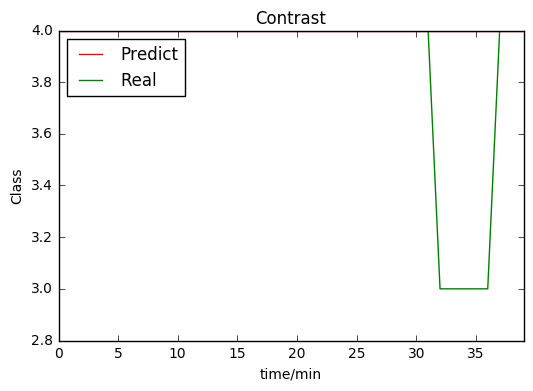

In [118]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-  
# 画出对比图，绿色表示实际值，红色表示预测值
import numpy as np    
import matplotlib.mlab as mlab    
import matplotlib.pyplot as plt    
# import ch
%matplotlib inline

# from pylab import *

# mpl.rcParams['font.sans-serif'] = ['SimHei']
# mpl.rcParams['axes.unicode_minus'] = False
Y1=[]
for i in range(60,100):
    nn_index = sess.run(pred1, feed_dict={xtr1: Xtr3, xte1: Xte3[i,:]})  
    Y1.append(np.argmax(train1_label[nn_index]))
Y2=[]
for i in range(60,100):
    Y2.append(np.argmax(test1_label[i]))

Y3 = pd.concat([Series(Y1),Series(Y2)],axis=1)
# set_ch()
Y3.columns = ['Predict','Real']
X=range(60,100) 
fig = plt.figure()  
Y3.plot(color=['red','green'],kind='line',use_index=False)  
#plt.bar(X,Y2,0.4,color="red")  
plt.xlabel("time/min")  
plt.ylabel("Class")  
plt.title("Contrast")  